# Investigating particle swarm optimisation in solving the Travelling Salesman Problem

## Abstract

Particle Swarm Optimisation (PSO) is a computational technique used to optimise a problem by iteratively improving the particles based on eachother, taking inspiration from nature, such as from birds in flight. PSO has many applications, from robotics to networks.

The Travelling Salesman Problem is a famous combinatorial optimisation problem which asks for shortest route by which a salesman can visit a set of locations and return home. It is NP-hard, meaning that there is no efficient algorithm that can solve it in polynomial time. Hence, approximation methods such as PSO are necessary.

In this notebook I investigate using PSO in solving instances of the Travelling Salesman Problem, taken from the TSPLIB dataset. A variety of instances, from small (burma14) to medium (att48) to large (lin105) were used in testing it.

I developed 2 variants of the optimiser, based on 2 approaches taken from 2 different papers:
<li>The first approach utilising velocity based swaps and greedy initialisation, the idea taken from this paper https://github.com/marcoscastro/tsp_pso/blob/master/references/paper.pdf</li>
<li>A second approach using segment reinsertion inspired by genetic mutations, inspired by https://www.tandfonline.com/doi/full/10.1080/23311835.2015.1048581#d1e1432.</li>

The results show that segment reinsertion is significantly better in performance than the other approach taken, and consistently provides optimal solutions, on par with and if not better than the results found in https://www.tandfonline.com/doi/full/10.1080/23311835.2015.1048581#d1e1432.

## Learning Objectives

<li>Explore the effectiveness of different particle swarm optimisation variants in solving instances of the Travelling Salesman Problem.</li>
<li>Investigate how tuning the parameters and balancing exploration with exploitation can impact the results.</li>
<li>Test the algorithms on a variety of problem instances, analysing their performance and results.</li>

## Contents

TSPLIB dataset overview  
Parsing TSP files - explain structure and code. Do some simple visualisations.

For all of the below, put some explanation and diagrams of what is happening to explain things:  
version 1 - theory and implementation  
version 2 - theory and implementation  

Results:  
Start with a simpler one like burma14, run all of the variants, and compare things like convergence speed, amount of iterations, solution accuracy. Compare with eachother.  
Maybe for each, do a test with basic parameters and another with tuned parameters.  
Repeat the process for 2 other increasingly complex ones, e.g. att48 and lin105.  

Comparison with other approaches - talk about how there were 2 papers that inspired the approaches, and how their results compared with mine.

Conclusion


## Modules

I used Pytorch for the efficient tensor operations and easy manipulation of data, Matplotlib for visualising the results, and the Requests library to get the data from the source.

In [2]:
import requests
import matplotlib.pyplot as plt
import torch
import pandas as pd
import time

## TSPLIB Dataset Overview

### Parsing

TSPLIB is an online dataset consisting of instances of the Travelling Salesman Problem. https://github.com/mastqe/tsplib. Each problem is contained in a .tsp file, with data contained in a format similar to YAML, but it needs a custom parser. The most important section is the NODE_COORD_SECTION, which contains the coordinates of the nodes/cities to be visited.

In [3]:
response = requests.get("https://raw.githubusercontent.com/mastqe/tsplib/refs/heads/master/burma14.tsp")
print(response.text)

NAME: burma14
TYPE: TSP
COMMENT: 14-Staedte in Burma (Zaw Win)
DIMENSION: 14
EDGE_WEIGHT_TYPE: GEO
EDGE_WEIGHT_FORMAT: FUNCTION 
DISPLAY_DATA_TYPE: COORD_DISPLAY
NODE_COORD_SECTION
   1  16.47       96.10
   2  16.47       94.44
   3  20.09       92.54
   4  22.39       93.37
   5  25.23       97.24
   6  22.00       96.05
   7  20.47       97.02
   8  17.20       96.29
   9  16.30       97.38
  10  14.05       98.12
  11  16.53       97.38
  12  21.52       95.59
  13  19.41       97.13
  14  20.09       94.55
EOF






When parsing the file, I created several data structures that will be necessary for the optimisation process.  
nodeCoordinates: This is a dictionary mapping node ID to the coordinates.  
coordinatesTensor: This is the tensor version of the dictionary, used for the actual algorithm.  
distanceMatrix: This is a construction of the edge weights, calculated using the euclidean distance between nodes.

In [35]:
class TspParser:
    name: str
    dimension: int
    nodeCoordinates: dict
    coordinatesTensor: list
    distanceMatrix: None

    #Parsing the file in the constructor
    def __init__(self, fileContent):
        self.nodeCoordinates = {}
        unprocessedData = fileContent.split("\n")
        isCoordinateSection = False
        for line in unprocessedData:
            line = line.strip()

            if "EOF" in line:
                break
            if "NAME" in line:
                nameData = line.split(":")
                self.name = nameData[1]
            if "DIMENSION" in line:
                dimensionData = line.split(":")
                self.dimension = int(dimensionData[1])
                
            if isCoordinateSection:
                line = line.strip()
                stringData = line.split()
                nodeId = int(stringData[0])
                x = float(stringData[1])
                y = float(stringData[2])
                self.nodeCoordinates[nodeId] = (x, y)
                
            if "NODE_COORD_SECTION" in line or "DISPLAY_DATA_SECTION" in line:
                isCoordinateSection = True

        self.coordinatesTensor = torch.tensor(list(self.nodeCoordinates.values()), dtype=torch.float32)
        self.computeDistanceMatrix()

    #separate function to compute the edge weights and put into a matrix
    def computeDistanceMatrix(self):
        nodeCount = self.coordinatesTensor.shape[0]
        distanceMatrix = torch.zeros((nodeCount + 1, nodeCount + 1))
        for i in range(1, nodeCount + 1):
            for j in range(1, nodeCount + 1):
                if i != j:
                    distanceMatrix[i, j] = torch.norm(self.coordinatesTensor[i - 1] - self.coordinatesTensor[j - 1])
        self.distanceMatrix = distanceMatrix
    
    #helper function to visualise the problem
    def plotCoords(self, plotEdges=True):
        nodeIds = list(self.nodeCoordinates.keys())
        xCoords = [coord[0] for coord in self.nodeCoordinates.values()]
        yCoords = [coord[1] for coord in self.nodeCoordinates.values()]
        plt.figure(figsize=(20, 20))
        plt.scatter(xCoords, yCoords, c='blue', marker='o', label='Nodes')
        
        for i, nodeId in enumerate(nodeIds):
            plt.text(xCoords[i], yCoords[i], str(nodeId), fontsize=12, ha='right', color='black')
    
        if plotEdges:
            nodeCount = len(self.nodeCoordinates)
            for i in range(1, nodeCount + 1): 
                for j in range(i + 1, nodeCount + 1):
                    if self.distanceMatrix[i, j] > 0:
                        x1, y1 = self.nodeCoordinates[i]
                        x2, y2 = self.nodeCoordinates[j]
                        plt.plot([x1, x2], [y1, y2], 'k-', lw=0.5, alpha=0.1)
        
        plt.xlabel('X Coordinates')
        plt.ylabel('Y Coordinates')
        plt.title('Node coordinates')
        plt.show()

### burma14

I will be using a variety of files from this dataset to represent a good range. The simplest one is burma14, with only 14 nodes.

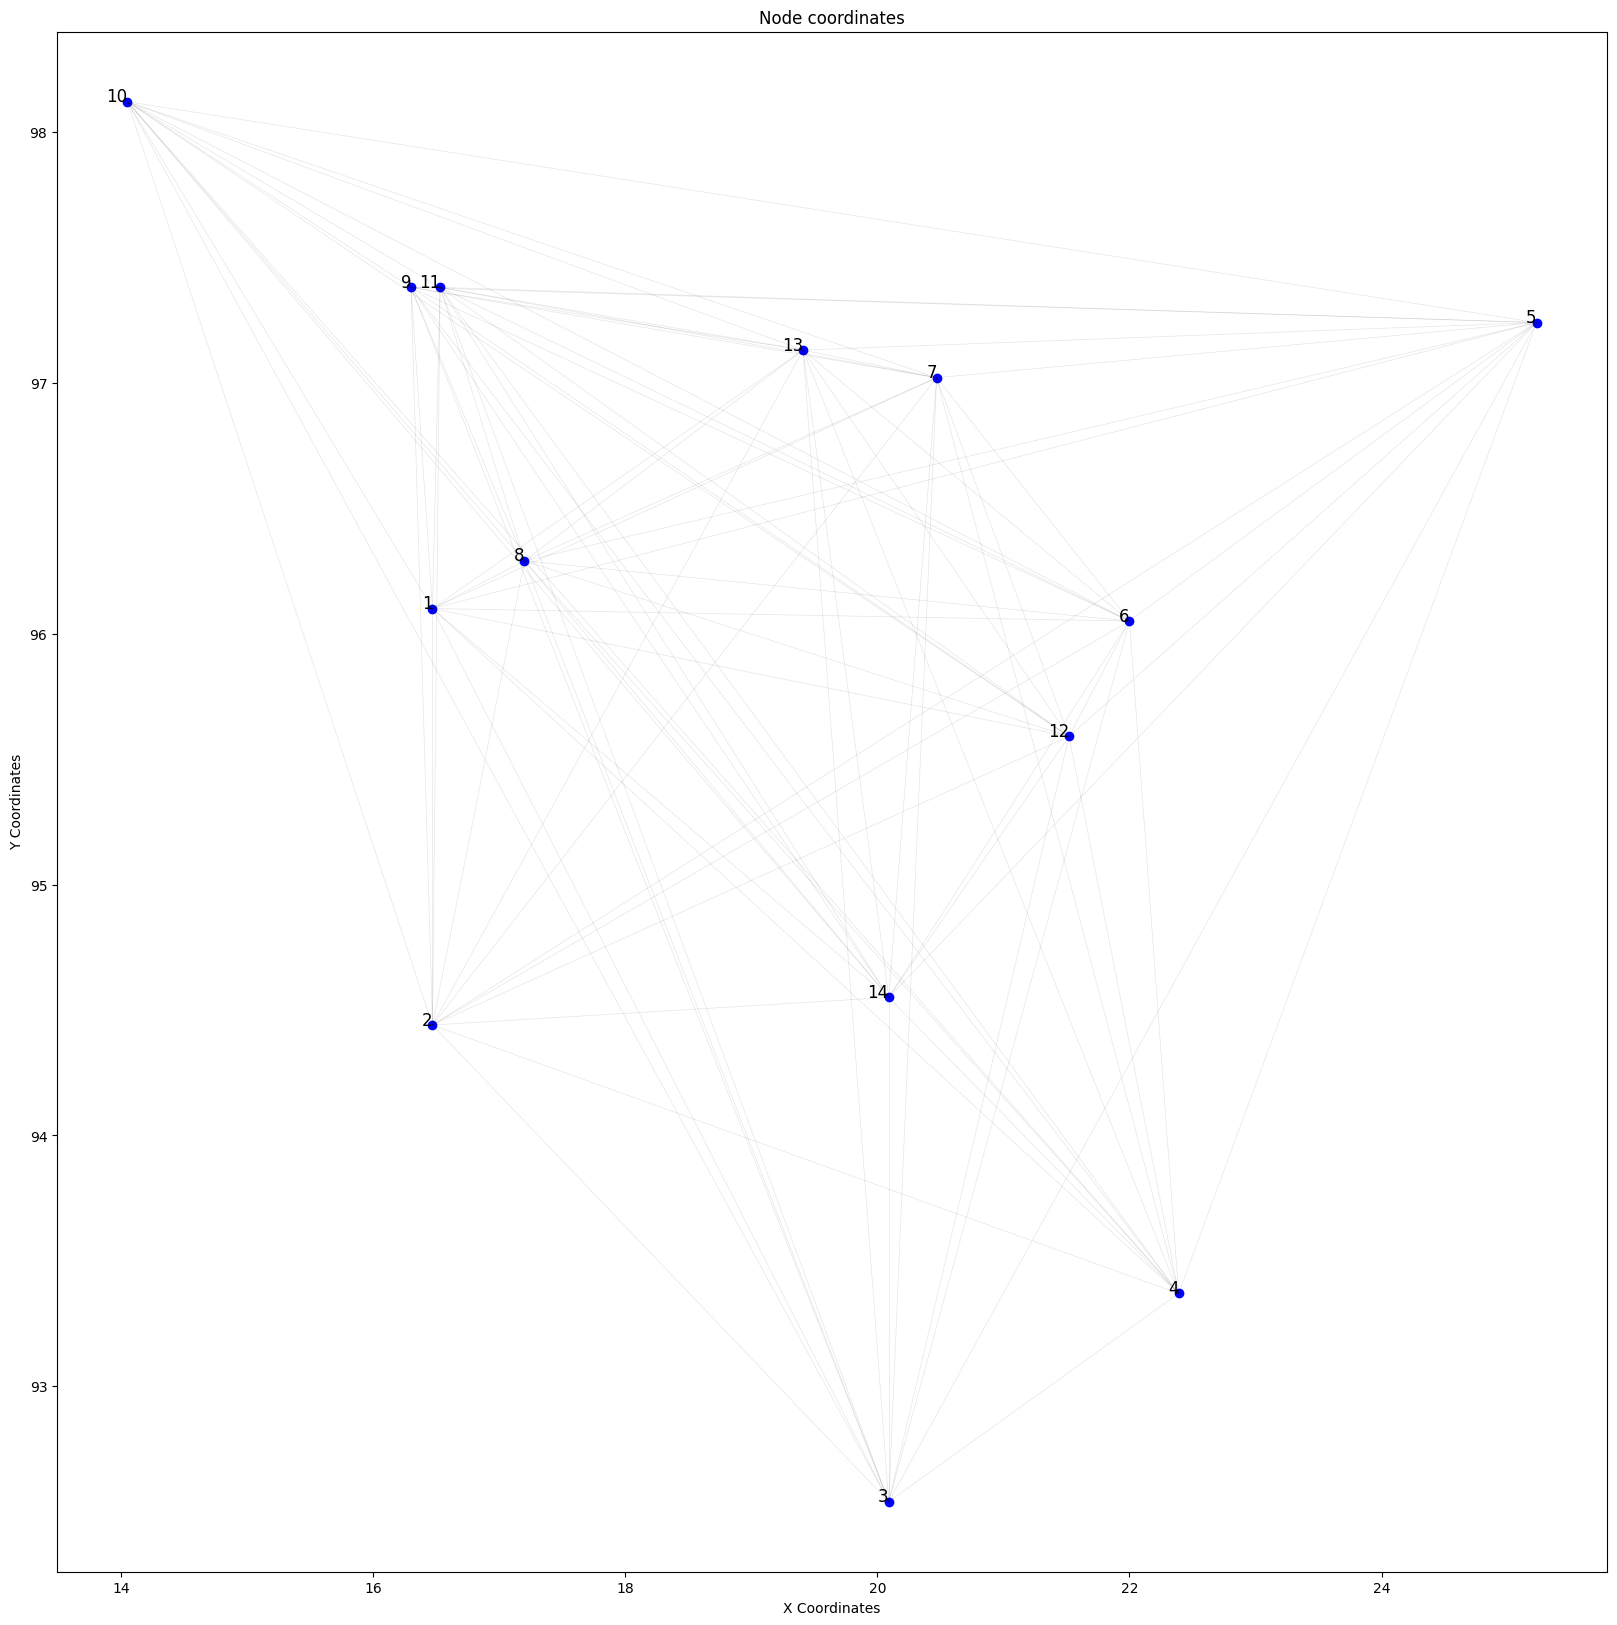

In [5]:
burma14 = TspParser(response.text)
burma14.plotCoords()

### att48

The att48 problem is a lot more complex, covering all 48 capitals of mainland USA. there is a wide distribution of nodes, with many being close together and others being separated significantly. This means that it is the perfect test for the PSO algorithms. It is large enough to pose a challenge for the algorithm, but small enough to be solved in a reasonable amount of time on my hardware.

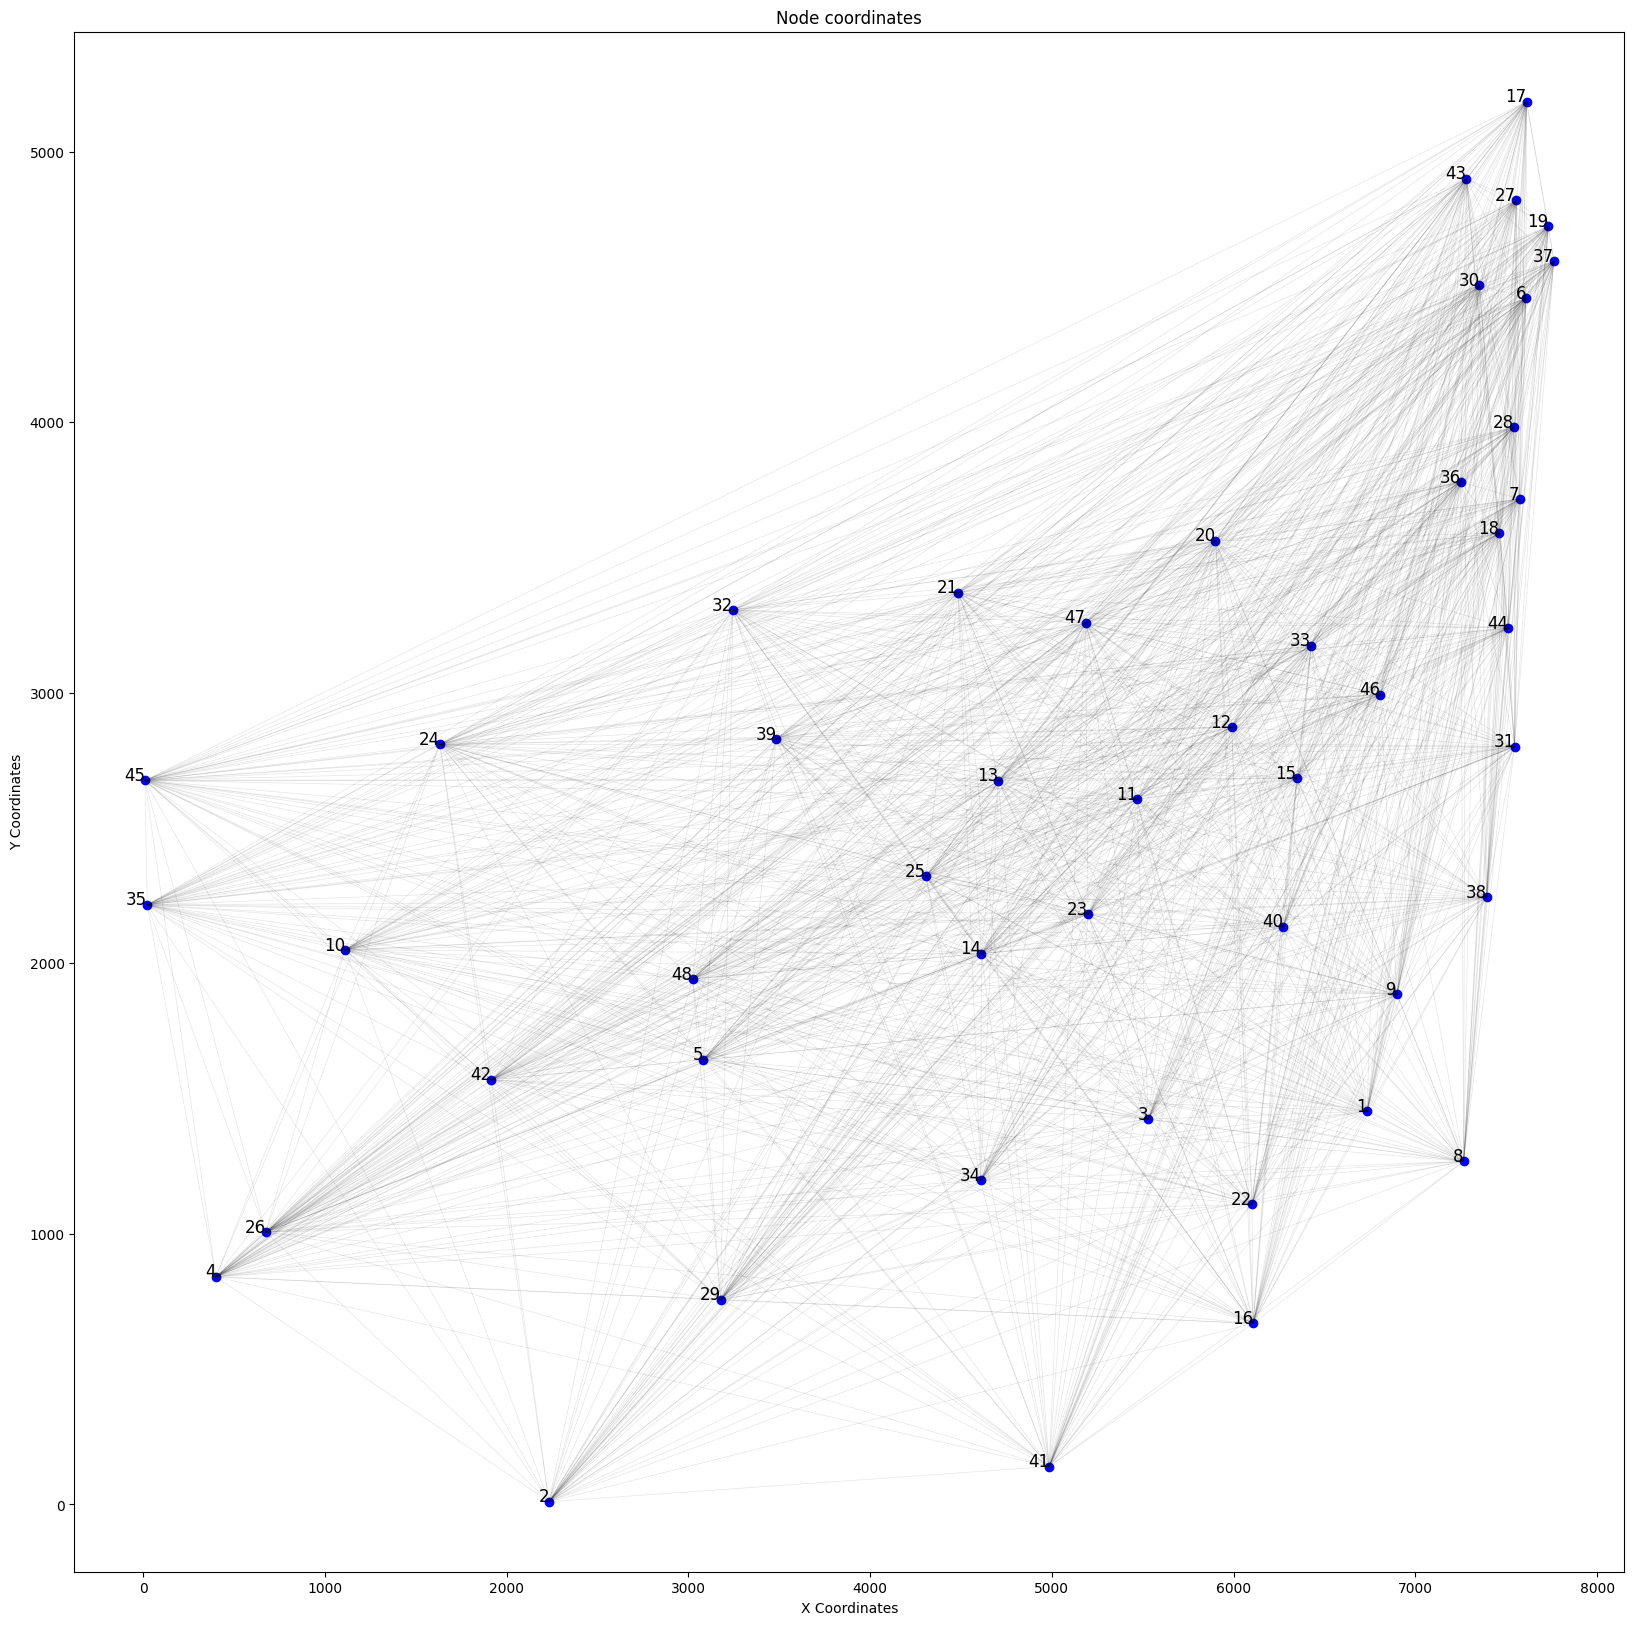

In [6]:
response = requests.get("https://raw.githubusercontent.com/mastqe/tsplib/refs/heads/master/att48.tsp")
att48 = TspParser(response.text)
att48.plotCoords()

### lin105

lin105 is a significantly larger problem than the others, and is more of a stretch goal to accomplish. Hardware and time constraints mean that the algorithms I have cannot solve these without thousands of iterations, which would potentially take hours, so I do not expect my algorithms to come to the optimal solution for this in a reasonable amount of time. The inclusion of this problem is more for comparison purposes.

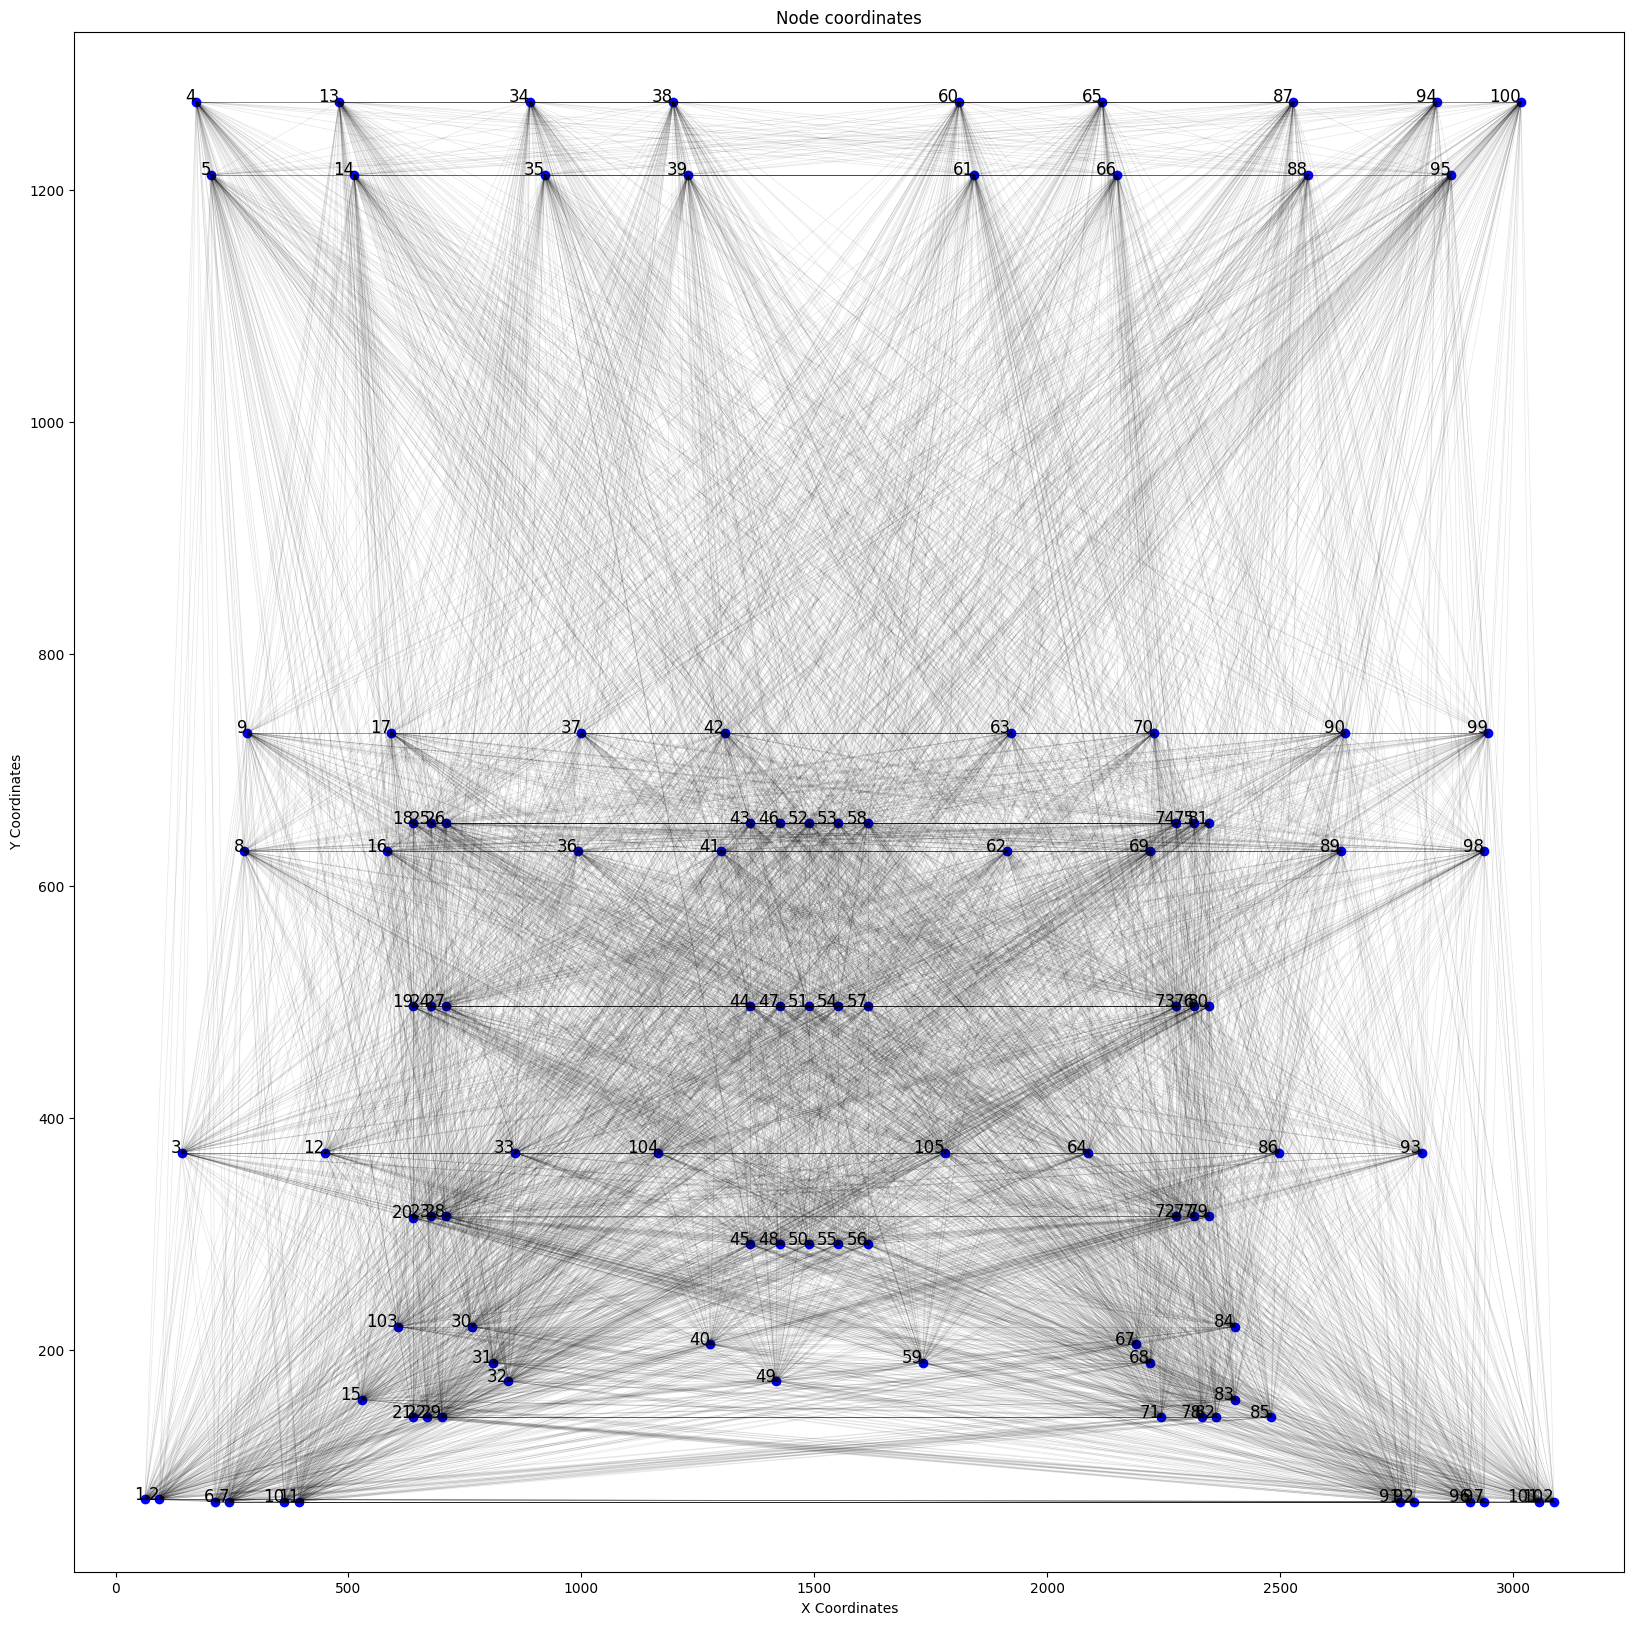

In [7]:
response = requests.get("https://raw.githubusercontent.com/mastqe/tsplib/refs/heads/master/lin105.tsp")
lin105 = TspParser(response.text)
lin105.plotCoords(plotEdges=True)

## PSO Implementations

### PSO Variant 1 (velocity based swap mutations)

Typically, in the PSO algorithm, there is a velocity component which updates the direction of the particle based on its current position, the local best position, and the global best position. However, for solving the Travelling Salesman Problem we cannot simply update a discrete value.

The approach I took for this problem is shown in this paper https://github.com/marcoscastro/tsp_pso/blob/master/references/paper.pdf. https://ieeexplore.ieee.org/document/1259748 Instead of a typical velocity, I use swap mutations. This involves a sequence of swap operations. represented as an array of arrays of length 2. Each pair indicates 2 indices that will have their values swapped.

In the image below, a swap operation is applied to a list, indicating that item at position 1 is swapped with the item at position 2.  
In the second line, a sequence of swaps is applied. This is the approach that will be taken with this variant of the PSO algorithm.

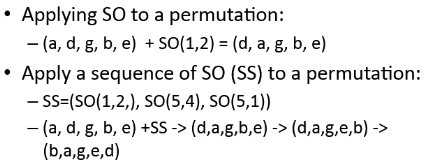

In this approach, the sequence of swaps is kept track of, in the velocity attribute of the particle. It is initialised as a random array of pairs, and updated based on the local best velocity and the global best velocity. There is also a randomisation element to it so that they do not converge on local optima too much 

Also, instead of initialising the particle's route randomly, it is done in a greedy way, with an algorithm that quickly takes the shortest possible nodes based on the distance matrix. It obviously does not provide optimal solutions straight away, but they speed up the overall convergence time and result in less iterations needed.

Regarding the parameters, there are several to consider:  
<li>swapCount: the amount of swap operations. In the image above, there are 3 operations, which I made the default option, but this can be changed.</li>
<li>alpha, beta, gamma: these 3 parameters dictate the proportions of how the swap operations are generated. They are generated with respect to the local best, global best, and random.  
In typical implementations, these might also be referred to as inertia, particle cognition, and social influence.</li>

In [52]:
class ParticleV1:
   
    def __init__(self, nodeCount, swapCount=3, greedy=True):
        self.swapCount = swapCount
        self.nodeCount = nodeCount
        if greedy:
            self.greedyInitialisation()
        else:
            self.position = torch.randperm(nodeCount) + 1
        self.fitnessValue = float("inf")
        self.localBestFitnessPosition = self.position.clone() 
        self.localBestFitnessValue = float("inf")
        self.velocity = [torch.randint(0, nodeCount, (2,)) for _ in range(swapCount)]
        self.localBestVelocity = self.velocity
    
    #gets the distance matrix as a static variable
    @staticmethod
    def updateDistanceMatrix(matrix):
        ParticleV1.distanceMatrix = matrix
            
    #calculate length of current route. Goes through every element in position, and uses distance matrix to get edge length
    def calculateRouteLength(self, position):
        tour = position.tolist() 
        totalDistance = sum(ParticleV1.distanceMatrix[tour[i], tour[i+1]] for i in range(len(tour)-1))
        totalDistance += ParticleV1.distanceMatrix[tour[-1], tour[0]]
        return totalDistance
    
    #initialises the particle positions in a greedy way
    def greedyInitialisation(self, k=5):
        nodeCount = ParticleV1.distanceMatrix.shape[0] - 1 
        startNode = torch.randint(1, nodeCount + 1, (1,)).item()
        route = [startNode] 
        unvisited = set(range(1, nodeCount + 1)) - {startNode} 

        currentNode = startNode
        while unvisited:
            distances = ParticleV1.distanceMatrix[currentNode, 1:]  
            nearestNeighbors = sorted([(distances[i], i + 1) for i in range(nodeCount) if (i + 1) in unvisited])[:k]
            nextNode = nearestNeighbors[torch.randint(0, len(nearestNeighbors), (1,)).item()][1]    
            route.append(nextNode)
            unvisited.remove(nextNode)
            currentNode = nextNode

        self.position = torch.tensor(route) 

    #updates velocity (swap sequence) according to the given proportions
    def updateVelocity(self, globalBestVelocity, alpha=1, beta=1, gamma=1):
        maxAttempts = 10
        newVelocity = []

        #calculate what proportions of the new velocity should be generated by the 3 parameters.
        #By default, if swapCount=3, then
        #1 swap will be random, 1 swap will be from the local best, and 1 swap will be from the global best.
        total = alpha + beta + gamma
        alphaCount = round((alpha / total) * self.swapCount)
        betaCount = round((beta / total) * self.swapCount)
        gammaCount = self.swapCount - (alphaCount + betaCount)

        def addSwaps(velocitySource, count_max):
            count = 0
            attempts = 0
            while count < count_max and attempts < maxAttempts:
                swapOperation = velocitySource[torch.randint(0, len(velocitySource), (1,)).item()]
                i, j = swapOperation.tolist()
                newPosition = self.position.clone()
                newPosition[i], newPosition[j] = newPosition[j].clone(), newPosition[i].clone()

                if self.calculateRouteLength(newPosition) < self.calculateRouteLength(self.position):
                    newVelocity.append(swapOperation)
                    count += 1
                attempts += 1
            
            #if attempts get exhausted, then simply add random swaps until filled
            while count < count_max:
                swapOperation = velocitySource[torch.randint(0, len(velocitySource), (1,)).item()]
                newVelocity.append(swapOperation)
                count += 1

        #add the swaps based on beta and gamma
        if betaCount > 0 and len(self.localBestVelocity) > 0:
            addSwaps(self.localBestVelocity, betaCount)
        if gammaCount > 0 and len(globalBestVelocity) > 0:
            addSwaps(globalBestVelocity, gammaCount)
            
        # Add random swaps to fill remaining slots (adding swaps based on alpha parameter)
        attempts = 0
        while len(newVelocity) < self.swapCount and attempts < maxAttempts:
            swapOperation = torch.randint(0, self.nodeCount, (2,))
            i, j = swapOperation.tolist()
            newPosition = self.position.clone()
            newPosition[i], newPosition[j] = newPosition[j].clone(), newPosition[i].clone()

            if self.calculateRouteLength(newPosition) < self.calculateRouteLength(self.position):
                newVelocity.append(swapOperation)
            attempts += 1
        self.velocity = newVelocity
        
    def swapMutation(self):  
        for [i, j] in self.velocity:
            self.position[i], self.position[j] = self.position[j].clone(), self.position[i].clone()

            

In [54]:
class ParticleSwarmOptimiserV1:
    history : dict
    timeTaken: float
        
    def __init__(self, nodeCount, nodeCoordinates, distanceMatrix, particleCount, swapCount, alpha=1, beta=1, gamma=1, greedyInitialisation=True):
        self.nodeCount = nodeCount
        self.nodeCoordinates = nodeCoordinates
        self.distanceMatrix = distanceMatrix
        ParticleV1.updateDistanceMatrix(distanceMatrix)
        self.particleSwarm = [ParticleV1(nodeCount, swapCount=swapCount, greedy=greedyInitialisation) for _ in range(particleCount)]
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.globalBestFitnessPosition = self.particleSwarm[0].position.clone()
        self.globalBestFitnessValue = float("inf")
        self.particleCount = particleCount
        self.globalBestVelocity = self.particleSwarm[0].velocity
    
    def getBestSolution(self):
        return self.globalBestFitnessPosition, self.globalBestFitnessValue, self.history, self.timeTaken

    def optimise(self, maxIterations):
        self.timeTaken = 0
        start = time.time()
        self.history = {}
        for iteration in range(maxIterations):
            #print(iteration)

            #iterates over each particle, updating local and global fitness values and routes as needed
            for particle in self.particleSwarm:
                fitness = particle.calculateRouteLength(particle.position)
                particle.fitnessValue = fitness
                if fitness < particle.localBestFitnessValue:
                    particle.localBestFitnessValue = fitness
                    particle.localBestFitnessPosition = particle.position.clone()
                    particle.localBestVelocity = particle.velocity

                if fitness < self.globalBestFitnessValue:
                    self.globalBestFitnessValue = fitness
                    self.globalBestFitnessPosition = particle.position.clone()
                    self.globalBestVelocity = particle.localBestVelocity

            for particle in self.particleSwarm:
                particle.swapMutation()
                particle.updateVelocity(self.globalBestVelocity, self.alpha, self.beta, self.gamma)

            self.history[iteration] = (self.globalBestFitnessPosition, self.globalBestFitnessValue)
        end = time.time()
        self.timeTaken = end - start
    
    #the below methods are just for analysis and visualisation purposes  
    def visualise(self, ax=None):
        plt.figure(figsize=(10, 6))
        if ax is None:        
            ax = plt.gca()
        xCoords = [coord[0] for coord in self.nodeCoordinates.values()]
        yCoords = [coord[1] for coord in self.nodeCoordinates.values()]
        plt.scatter(xCoords, yCoords, c='blue', marker='o', label='Nodes')
        nodeCount = len(self.nodeCoordinates)
        for i in range(1, nodeCount + 1):
            for j in range(i + 1, nodeCount + 1): 
                if self.distanceMatrix[i, j] > 0:
                    x1, y1 = self.nodeCoordinates[i ]
                    x2, y2 = self.nodeCoordinates[j]
                    plt.plot([x1, x2], [y1, y2], 'k-', lw=0.5, alpha=0.1)

        xValues = []
        yValues = []
        bestPath = self.globalBestFitnessPosition.tolist()

        for i in bestPath:
            coords = self.nodeCoordinates[i]
            xValues.append(coords[0])
            yValues.append(coords[1])

        for i in range(len(xValues) - 1):
            plt.plot(xValues[i:i+2], yValues[i:i+2], 'ro-', markersize=5, label='Best Path' if i == 0 else "")
        plt.plot([xValues[-1], xValues[0]], [yValues[-1], yValues[0]], 'ro-', markersize=5)
        plt.xlabel('X Coordinates')
        plt.ylabel('Y Coordinates')
        plt.title('Node Coordinates')
        plt.legend()
        plt.show() 
        
    def showIterationHistory(self, ax=None):
        table_data = []
        for iteration, (position, value) in self.history.items():
            position_list = position.tolist() 
            value = value.item()
            table_data.append([iteration, position_list, value])

        df = pd.DataFrame(table_data, columns=["Iteration", "Position", "Value"])

        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 6))
        ax.axis('off')
        table = ax.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center', colColours=["lightgrey"]*df.shape[1])
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.5, 1.5) 
        plt.show()
        
    def showLossAgainstIterationGraph(self):
        iterations = []
        values = []
        for iteration, (position, value) in self.history.items():
            values.append(value.item())
            iterations.append(iteration)

        plt.figure(figsize=(10, 6))
        plt.plot(iterations, values, marker='o', color='b', label='Fitness Value')
        plt.xlabel('Iteration')
        plt.ylabel('Value')
        plt.title('Iteration vs Value')
        plt.grid(True)
        plt.legend()
        plt.show()
        

## PSO variant 2 (genetic inspired segment reinsertion)

The third variant is inspired by the paper https://www.tandfonline.com/doi/full/10.1080/23311835.2015.1048581. This paper goes through the use of genetic crossover operations on the particle paths. Instead of directly implementing this however, I implemented a somewhat different segment reinsertion method that takes entire segments from the current, local best, and global best, and strategically combines these into a brand new path.

In [56]:
class ParticleV2:
   
    def __init__(self, nodeCount, swapCount=3, greedy=True):
        self.swapCount = swapCount
        self.nodeCount = nodeCount
        if greedy:
            self.greedyInitialisation()
        else:
            self.position = torch.randperm(nodeCount) + 1
        self.fitnessValue = float("inf")
        self.localBestFitnessPosition = self.position.clone() 
        self.localBestFitnessValue = float("inf")
    
    @staticmethod
    def updateDistanceMatrix(matrix):
        ParticleV2.distanceMatrix = matrix
            
    #calculate length of current route. Goes through every element in position, and uses distance matrix to get edge length
    def calculateRouteLength(self, position):
        tour = position.tolist() 
        totalDistance = sum(ParticleV1.distanceMatrix[tour[i], tour[i+1]] for i in range(len(tour)-1))
        totalDistance += ParticleV1.distanceMatrix[tour[-1], tour[0]]
        return totalDistance
    
    #initialises the particle positions in a greedy way
    def greedyInitialisation(self, k=5):
        nodeCount = ParticleV1.distanceMatrix.shape[0] - 1 
        startNode = torch.randint(1, nodeCount + 1, (1,)).item()
        route = [startNode] 
        unvisited = set(range(1, nodeCount + 1)) - {startNode} 

        currentNode = startNode
        while unvisited:
            distances = ParticleV1.distanceMatrix[currentNode, 1:]  
            nearestNeighbors = sorted([(distances[i], i + 1) for i in range(nodeCount) if (i + 1) in unvisited])[:k]
            nextNode = nearestNeighbors[torch.randint(0, len(nearestNeighbors), (1,)).item()][1]    
            route.append(nextNode)
            unvisited.remove(nextNode)
            currentNode = nextNode

        self.position = torch.tensor(route) 

    #similarly to V1, calculate what proportions should be generated by the 3 parameters.
    def swapMutation(self, globalBestPath, alpha=1, beta=1, gamma=1):  
        newPosition = self.position.tolist() 
        innerCount = 0
        foundBetter = False

        total = alpha + beta + gamma
        alphaCount = round((alpha / total) * self.swapCount)
        betaCount = round((beta / total) * self.swapCount)
        gammaCount = self.swapCount - (alphaCount + betaCount)

        def extractAndInsertSegment(sourcePath):
            segmentLength = torch.randint(1, max(2, self.nodeCount // 4), (1,)).item()
            startIdx = torch.randint(0, self.nodeCount - segmentLength, (1,)).item()
            segment = sourcePath[startIdx:startIdx + segmentLength]
            tempPosition = [node for node in newPosition if node not in segment]
            insertIdx = torch.randint(0, len(tempPosition) + 1, (1,)).item()
            tempPosition[insertIdx:insertIdx] = segment
        
            return tempPosition

        #repeatedly do segment reinsertion according to the proportions given
        while not foundBetter and innerCount < 10:
            candidates = []
            for _ in range(alphaCount):
                candidates.append(extractAndInsertSegment(self.position))
            for _ in range(betaCount):
                candidates.append(extractAndInsertSegment(self.localBestFitnessPosition))
            for _ in range(gammaCount):
                candidates.append(extractAndInsertSegment(globalBestPath))

            bestCandidate = min(
                (torch.tensor(c, dtype=torch.long) for c in candidates),
                key=lambda pos: self.calculateRouteLength(pos)
            )

            if self.calculateRouteLength(bestCandidate) < self.calculateRouteLength(self.position):
                self.position = bestCandidate.clone()
                foundBetter = True
            innerCount += 1


In [72]:
class ParticleSwarmOptimiserV2:
    history : dict
    timeTaken: float
        
    def __init__(self, nodeCount, nodeCoordinates, distanceMatrix, particleCount, swapCount, alpha=1, beta=1, gamma=1, greedyInitialisation=True):
        self.nodeCount = nodeCount
        self.nodeCoordinates = nodeCoordinates
        self.distanceMatrix = distanceMatrix
        ParticleV2.updateDistanceMatrix(distanceMatrix)
        self.particleSwarm = [ParticleV2(nodeCount, swapCount=swapCount, greedy=greedyInitialisation) for _ in range(particleCount)]
        self.beta = beta
        self.alpha = alpha
        self.gamma = gamma
        self.globalBestFitnessPosition = self.particleSwarm[0].position.clone()
        self.globalBestFitnessValue = float("inf")
        self.particleCount = particleCount
    
    def getBestSolution(self):
        return self.globalBestFitnessPosition, self.globalBestFitnessValue, self.history, self.timeTaken

    def optimise(self, maxIterations):
        self.timeTaken = 0
        start = time.time()
        self.history = {}

        #again, iterate over each particle and update the local and global bests accordingly
        for iteration in range(maxIterations):
            #print(iteration)
            for particle in self.particleSwarm:
                fitness = particle.calculateRouteLength(particle.position)
                particle.fitnessValue = fitness
                if fitness < particle.localBestFitnessValue:
                    particle.localBestFitnessValue = fitness
                    particle.localBestFitnessPosition = particle.position.clone()

                if fitness < self.globalBestFitnessValue:
                    self.globalBestFitnessValue = fitness
                    self.globalBestFitnessPosition = particle.position.clone()

            for particle in self.particleSwarm:
                particle.swapMutation(self.globalBestFitnessPosition, self.alpha, self.beta, self.gamma)

            self.history[iteration] = (self.globalBestFitnessPosition, self.globalBestFitnessValue)
        end = time.time()
        self.timeTaken = end - start
        
    #methods for analysis and visualisation
    def visualise(self, ax=None):
        plt.figure(figsize=(10, 6))
        if ax is None:        
            ax = plt.gca()
        xCoords = [coord[0] for coord in self.nodeCoordinates.values()]
        yCoords = [coord[1] for coord in self.nodeCoordinates.values()]
        plt.scatter(xCoords, yCoords, c='blue', marker='o', label='Nodes')
        nodeCount = len(self.nodeCoordinates)
        for i in range(1, nodeCount + 1):
            for j in range(i + 1, nodeCount + 1): 
                if self.distanceMatrix[i, j] > 0:
                    x1, y1 = self.nodeCoordinates[i ]
                    x2, y2 = self.nodeCoordinates[j]
                    plt.plot([x1, x2], [y1, y2], 'k-', lw=0.5, alpha=0.1)

        xValues = []
        yValues = []
        bestPath = self.globalBestFitnessPosition.tolist()

        for i in bestPath:
            coords = self.nodeCoordinates[i]
            xValues.append(coords[0])
            yValues.append(coords[1])

        for i in range(len(xValues) - 1):
            plt.plot(xValues[i:i+2], yValues[i:i+2], 'ro-', markersize=5, label='Best Path' if i == 0 else "")
        plt.plot([xValues[-1], xValues[0]], [yValues[-1], yValues[0]], 'ro-', markersize=5)
        plt.xlabel('X Coordinates')
        plt.ylabel('Y Coordinates')
        plt.title('Node Coordinates')
        plt.legend()
        plt.show() 
        
    def showIterationHistory(self, ax=None):
        table_data = []
        for iteration, (position, value) in self.history.items():
            position_list = position.tolist() 
            value = value.item()
            table_data.append([iteration, position_list, value])

        df = pd.DataFrame(table_data, columns=["Iteration", "Position", "Value"])

        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 6))
        ax.axis('off')
        table = ax.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center', colColours=["lightgrey"]*df.shape[1])
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.5, 1.5) 
        plt.show()
        
    def showLossAgainstIterationGraph(self):
        iterations = []
        values = []
        for iteration, (position, value) in self.history.items():
            values.append(value.item())
            iterations.append(iteration)

        plt.figure(figsize=(10, 6))
        plt.plot(iterations, values, marker='o', color='b', label='Fitness Value')
        plt.xlabel('Iteration')
        plt.ylabel('Value')
        plt.title('Iteration vs Value')
        plt.grid(True)
        plt.legend()
        plt.show()


## Analysis

For the analysis, I made a function that creates a sequence of data including graphs and tables, so that the metrics of each variant can be compared, as well as the solutions that they generate.

In [73]:
def compareBestRoutes(psoV1, psoV2):
    plt.figure(figsize=(10, 6))
    ax = plt.gca()

    # Scatter plot for nodes
    xCoords = [coord[0] for coord in psoV1.nodeCoordinates.values()]
    yCoords = [coord[1] for coord in psoV1.nodeCoordinates.values()]
    ax.scatter(xCoords, yCoords, c='blue', marker='o', label='Nodes')

    def plotBestPath(pso, color, linestyle, offset, label):
        bestPath = pso.globalBestFitnessPosition.tolist()

        xValues = [pso.nodeCoordinates[i][0] + offset for i in bestPath]
        yValues = [pso.nodeCoordinates[i][1] + offset for i in bestPath]

        ax.plot(xValues, yValues, linestyle, color=color, markersize=5, alpha=0.8, label=label)
        ax.plot([xValues[-1], xValues[0]], [yValues[-1], yValues[0]], linestyle, color=color, markersize=5, alpha=0.8)

    # Plot paths with slight offset and different styles
    plotBestPath(psoV1, 'r', 'o-', 0.01, 'Best Path (Variant 1)')  # Offset variant 1 slightly
    plotBestPath(psoV2, 'g', 'o--', -0.01, 'Best Path (Variant 2)')  # Offset variant 2 in opposite direction

    ax.set_xlabel('X Coordinates')
    ax.set_ylabel('Y Coordinates')
    ax.set_title('Comparison of Best Paths')
    ax.legend()
    plt.show()

def compareLossCurves(psoV1, psoV2):
    plt.figure(figsize=(10, 6))

    def extractLossData(pso):
        iterations = []
        values = []
        for iteration, (_, value) in pso.history.items():
            iterations.append(iteration)
            values.append(value.item())
        return iterations, values

    # Extract loss data for both variants
    iterations1, values1 = extractLossData(psoV1)
    iterations2, values2 = extractLossData(psoV2)

    # Plot both loss curves
    plt.plot(iterations1, values1, marker='o', linestyle='-', color='r', label='Variant 1')
    plt.plot(iterations2, values2, marker='s', linestyle='--', color='g', label='Variant 2')

    plt.xlabel('Iteration')
    plt.ylabel('Fitness Value')
    plt.title('Comparison of Fitness Value over Iterations')
    plt.grid(True)
    plt.legend()
    plt.show()

### burma14 Analysis

run all of the variants, and compare things like convergence speed, amount of iterations, solution accuracy. Compare with eachother.  
put graphs of loss against epochs, speed comparisons, iteration comparisons, accuracy.
Maybe for each, do a test with basic parameters and another with tuned parameters. need to implement modifiable parameters.

First I ran V1 on this problem, with some simple parameters:


Best Path Found: [10, 9, 11, 1, 8, 13, 7, 6, 5, 12, 4, 3, 14, 2]
Best Cost: tensor(32.2441)
time taken: 4.661736726760864


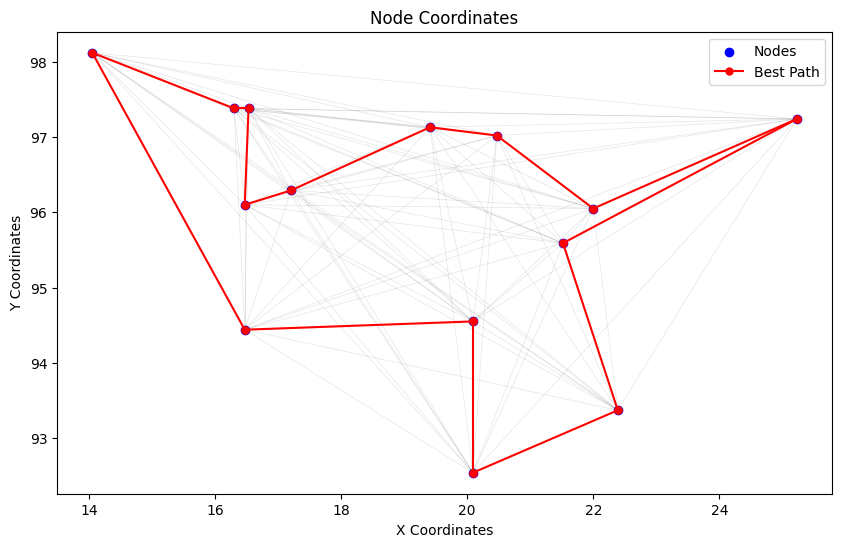

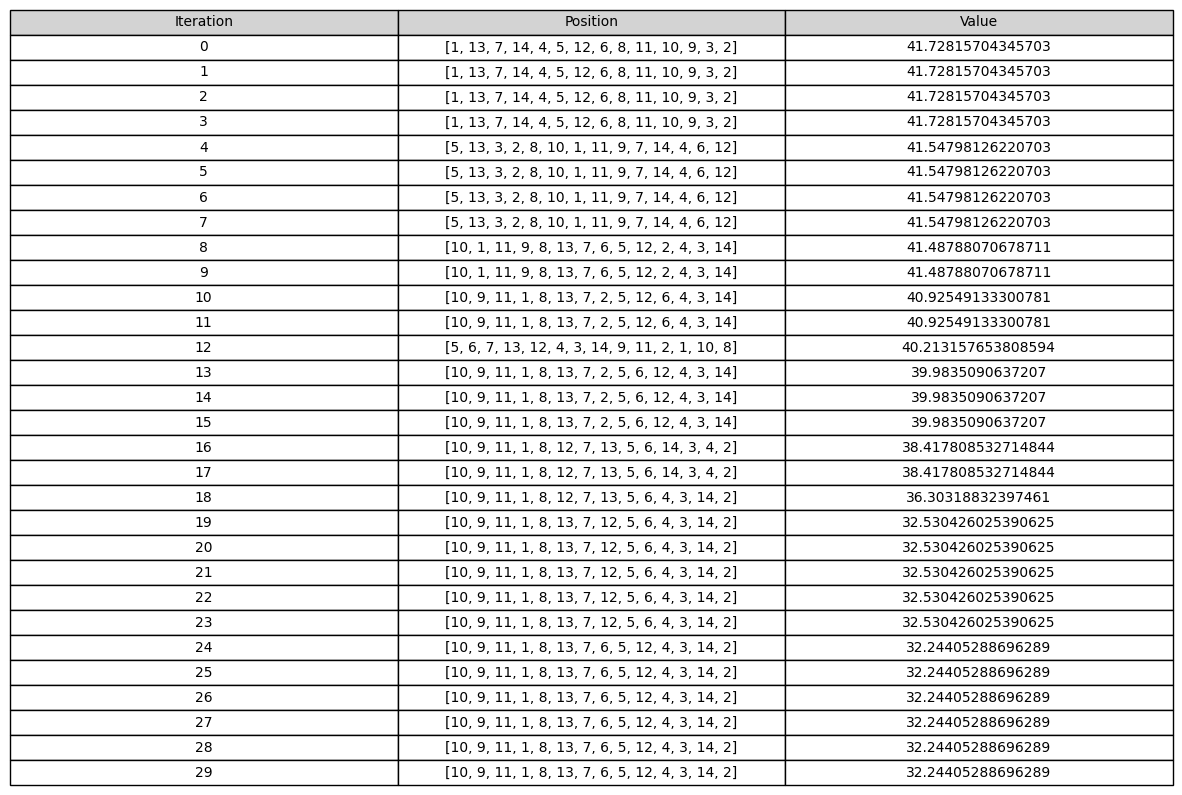

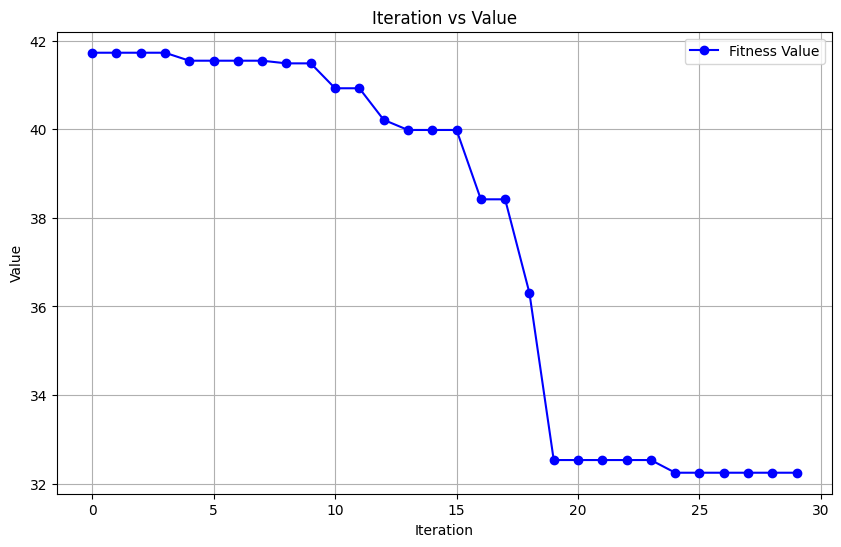

In [61]:
particle_count = 10
max_iterations = 30
alpha = 1
beta = 1
gamma = 1

psoV1 = ParticleSwarmOptimiserV1(
    nodeCount=burma14.dimension,
    nodeCoordinates = burma14.nodeCoordinates,
    distanceMatrix = burma14.distanceMatrix,
    particleCount=particle_count,
    swapCount = 3,
    alpha = alpha,
    beta = beta,
    gamma = gamma,
    greedyInitialisation = True
)

psoV1.optimise(max_iterations)
bestPathV1, bestCostV1, historyV1, timeTakenV1 = psoV1.getBestSolution()

print("\nBest Path Found:", bestPathV1.tolist())
print("Best Cost:", bestCostV1)
print(f"time taken: {timeTakenV1}")
psoV1.visualise()
psoV1.showIterationHistory()
psoV1.showLossAgainstIterationGraph()

Then I ran V2 on this problem with the exact same parameters:


Best Path Found: [10, 9, 11, 8, 13, 7, 12, 6, 5, 4, 3, 14, 2, 1]
Best Cost: tensor(30.8785)
time taken: 5.371567726135254


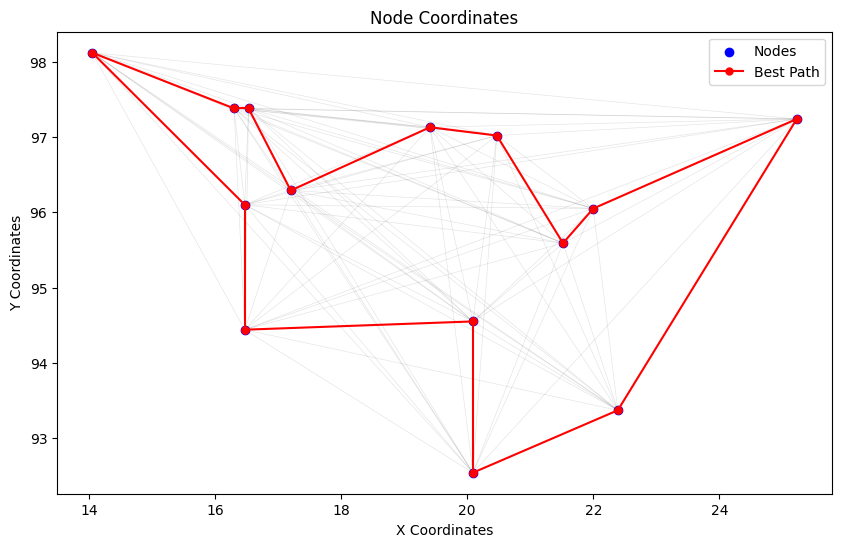

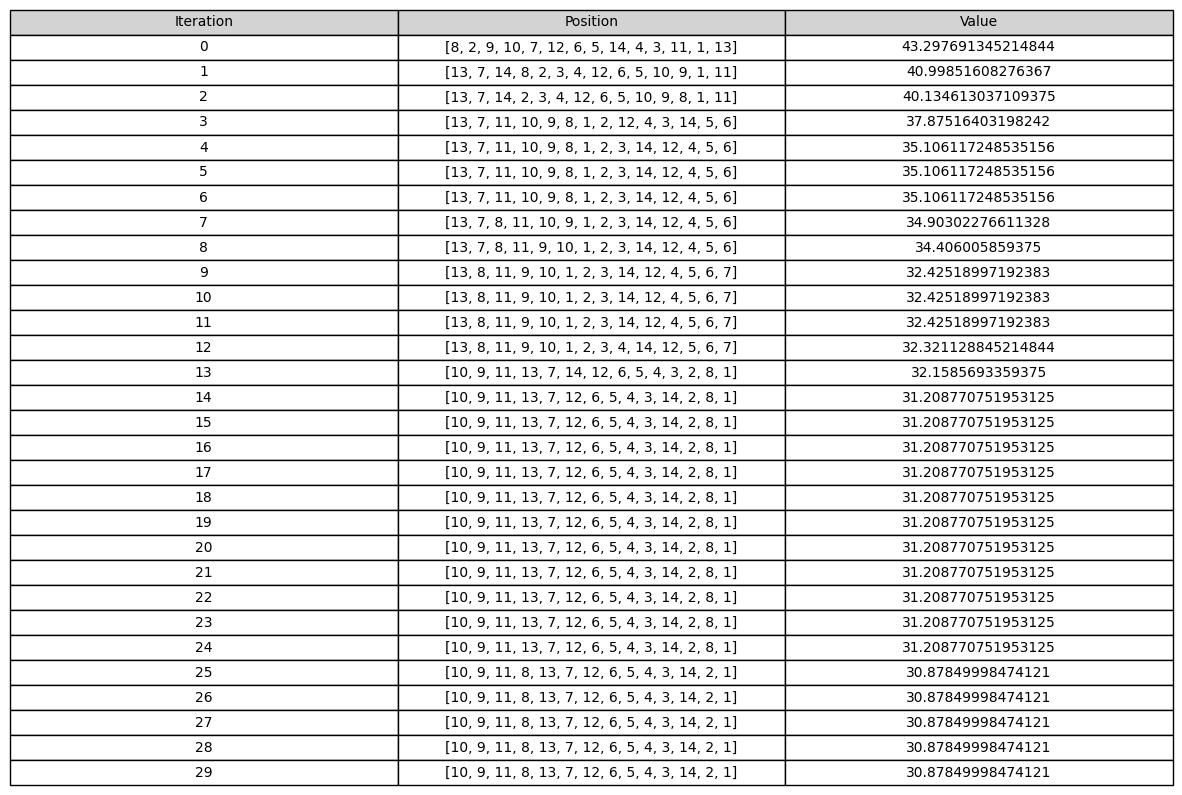

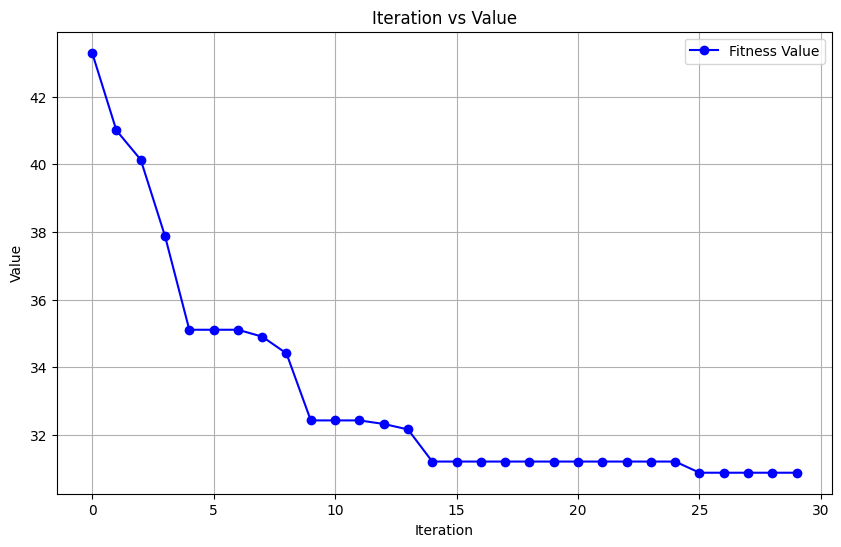

In [64]:
particle_count = 10
max_iterations = 30
alpha = 1
beta = 1
gamma = 1

psoV2 = ParticleSwarmOptimiserV2(
    nodeCount=burma14.dimension,
    nodeCoordinates = burma14.nodeCoordinates,
    distanceMatrix = burma14.distanceMatrix,
    particleCount=particle_count,
    swapCount = 3,
    alpha = alpha,
    beta = beta,
    gamma = gamma,
    greedyInitialisation = True
)

psoV2.optimise(max_iterations)
bestPathV2, bestCostV2, historyV2, timeTakenV2 = psoV2.getBestSolution()

print("\nBest Path Found:", bestPathV2.tolist())
print("Best Cost:", bestCostV2)
print(f"time taken: {timeTakenV2}")
psoV2.visualise()
psoV2.showIterationHistory()
psoV2.showLossAgainstIterationGraph()

If we compare the results, we can see that variant 2 performs better and faster.

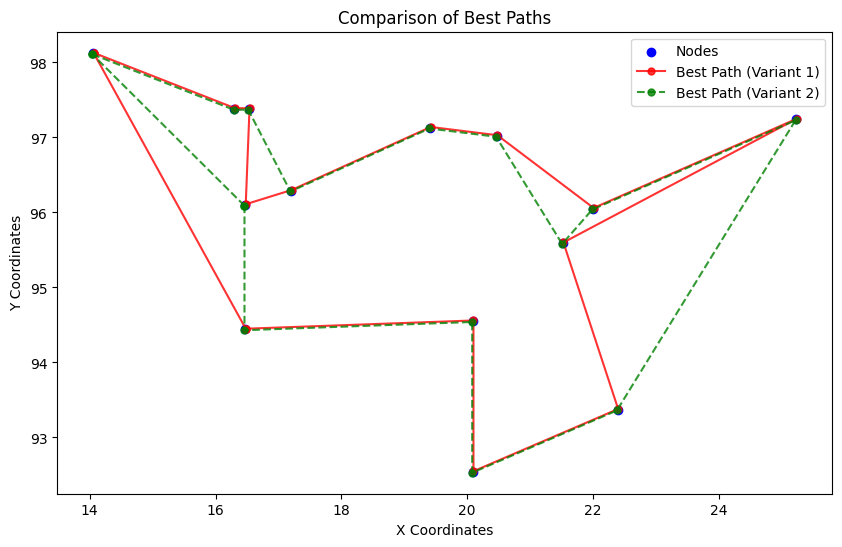

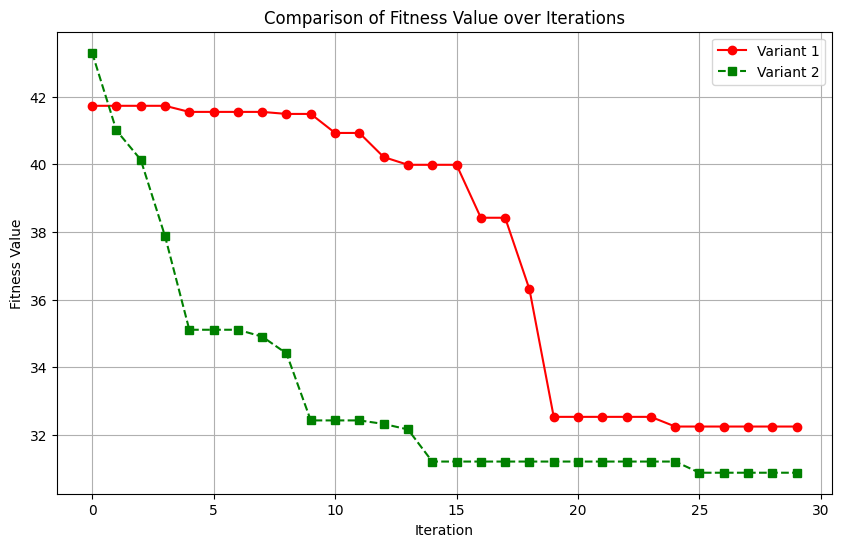

In [74]:
compareBestRoutes(psoV1, psoV2)
compareLossCurves(psoV1, psoV2)

Tune hyperparameters and discuss why we do what we do.

Then discuss the results of the tuned hyperparameters.

### att48 Analysis

Repeat the same process that we did in att48. explain what is expected in terms of results

In [ ]:
particle_count = 50
max_iterations = 100
inertia = 0.8
c1 = 1.5
c2 = 1.5

pso = ParticleSwarmOptimiserV2(
    nodeCount=att48.dimension,
    distanceMatrix = att48.distanceMatrix,
    particleCount=particle_count,
    inertia=inertia,
    particleCognition=c1,
    socialInfluence=c2
)

pso.optimise( max_iterations)
best_path, best_cost = pso.getBestSolution()

print("\nBest Path Found:", best_path.tolist())
print("Best Cost:", best_cost)

plotBestPath(att48.nodeCoordinates, att48.distanceMatrix, best_path)

### lin105 Analysis

In [ ]:
particle_count = 50
max_iterations = 100
inertia = 0.8
c1 = 1.5
c2 = 1.5

pso = ParticleSwarmOptimiserV2(
    nodeCount=lin105.dimension,
    distanceMatrix = lin105.distanceMatrix,
    particleCount=particle_count,
    inertia=inertia,
    particleCognition=c1,
    socialInfluence=c2
)

pso.optimise( max_iterations)
best_path, best_cost = pso.getBestSolution()

print("\nBest Path Found:", best_path.tolist())
print("Best Cost:", best_cost)

plotBestPath(lin105.nodeCoordinates, lin105.distanceMatrix, best_path)

## Comparison with Other Approaches

## Conclusion and future work

## References

https://github.com/mastqe/tsplib  
https://www.tandfonline.com/doi/full/10.1080/23311835.2015.1048581  
https://ieeexplore.ieee.org/document/1259748  
https://github.com/marcoscastro/tsp_pso/blob/master/references/paper.pdf
    